In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

In [2]:
evals = pd.read_parquet("data/evals.parquet")

date_cols = evals.columns[evals.columns.str.contains("date")]
evals[date_cols] = evals[date_cols].apply(pd.to_datetime)

# filter out the last time step for alignment
evals = evals[evals["test_end_date"] < "2022-10-01"]

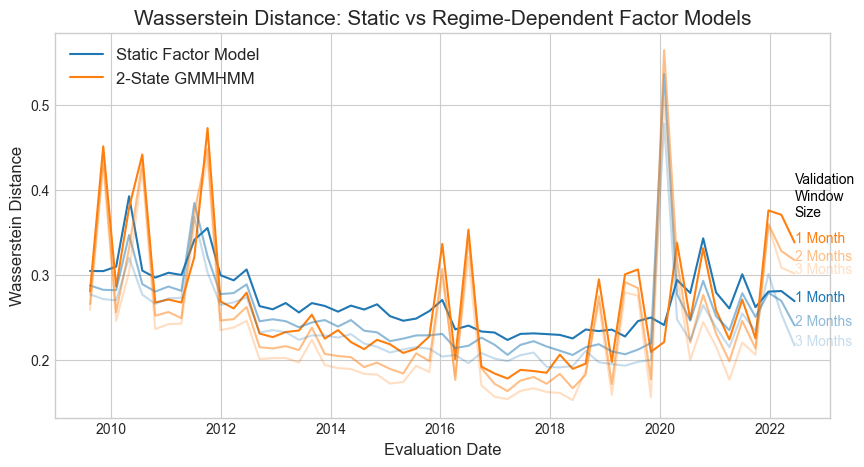

In [7]:
# filter to compare results for 2 regimes vs baseline
# fix to the larger train and test window sizes
train_window_size = 3750
stride = 62
n_regimes = 2

fig, ax = plt.subplots(1, 1, figsize=(10, 5))


def annotate_last_point(ax, line, text):
    xdata, ydata = line.get_data()
    last_point = (xdata[-1], ydata[-1])
    ax.annotate(
        text,
        xy=last_point,
        textcoords="data",
        color=line.get_color(),
        alpha=line.get_alpha(),
    )


colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]


static = evals.loc[train_window_size, 20, stride, 1].loc[["static"]]
hmm2 = evals.loc[train_window_size, 20, stride, n_regimes].loc[["hmm_base"]]
hmm2 = hmm2["wasserstein_distance"].unstack(level="factor_model_name")
static = static["wasserstein_distance"].unstack(level="factor_model_name")

ax.plot(
    static.index,
    static,
    label="Static Factor Model",
    linestyle="-",
    color=colors[0],
    alpha=1,
)
ax.plot(
    hmm2.index,
    hmm2,
    label="2-State GMMHMM",
    linestyle="-",
    color=colors[1],
    alpha=1,
)

annotate_last_point(ax, ax.lines[0], "1 Month")
annotate_last_point(ax, ax.lines[1], "1 Month")


############################################################

static = evals.loc[train_window_size, 40, stride, 1].loc[["static"]]
hmm2 = evals.loc[train_window_size, 40, stride, n_regimes].loc[["hmm_base"]]
hmm2 = hmm2["wasserstein_distance"].unstack(level="factor_model_name")
static = static["wasserstein_distance"].unstack(level="factor_model_name")

ax.plot(static.index, static, linestyle="-", color=colors[0], alpha=0.5)
ax.plot(hmm2.index, hmm2, linestyle="-", color=colors[1], alpha=0.5)

annotate_last_point(ax, ax.lines[2], "2 Months")
annotate_last_point(ax, ax.lines[3], "2 Months")

############################################################

static = evals.loc[train_window_size, 62, stride, 1].loc[["static"]]
hmm2 = evals.loc[train_window_size, 62, stride, n_regimes].loc[["hmm_base"]]
hmm2 = hmm2["wasserstein_distance"].unstack(level="factor_model_name")
static = static["wasserstein_distance"].unstack(level="factor_model_name")

ax.plot(static.index, static, linestyle="-", color=colors[0], alpha=0.25)
ax.plot(hmm2.index, hmm2, linestyle="-", color=colors[1], alpha=0.25)

annotate_last_point(ax, ax.lines[4], "3 Months")
annotate_last_point(ax, ax.lines[5], "3 Months")

############################################################

# static = evals.loc[train_window_size, 250, stride, 1].loc[["static"]]
# hmm2 = evals.loc[train_window_size, 250, stride, n_regimes].loc[['hmm_base']]
# hmm2 = hmm2["wasserstein_distance"].unstack(level="factor_model_name")
# static = static["wasserstein_distance"].unstack(level="factor_model_name")

# ax.plot(static.index, static, linestyle="-", color=colors[0], alpha=0.1)
# ax.plot(hmm2.index, hmm2, linestyle="-", color=colors[1], alpha=0.1)

# annotate_last_point(ax, ax.lines[6], "1 Year")
# annotate_last_point(ax, ax.lines[7], "1 Year")

############################################################

xdata, ydata = ax.lines[0].get_data()
last_point = (xdata[-1], ydata[-1] + 0.1)
ax.annotate("Validation\nWindow\nSize", xy=last_point, textcoords="data", color="black")


ax.set_xlabel("Evaluation Date", fontsize=12)
ax.set_ylabel("Wasserstein Distance", fontsize=12)
ax.set_title("Wasserstein Distance: Static vs Regime-Dependent Factor Models", fontsize=15)
ax.legend(fontsize=12)
plt.show()

In [97]:
benchmark_cols = [
    "static",
    "hmm_base",
]

selection_cols = benchmark_cols + [
    "hmm_seq",
    "hmm_shap",
    "hmm_heir",
    "hmm_rppca",
]

engineering_cols = benchmark_cols + [
    "hmm_boost",
    "hmm_rppca_eng",
]

selection_and_engineering_cols = benchmark_cols + [
    "hmm_heir_boost",
    "hmm_heir_rppca_eng",
    "hmm_shap_boost",
    "hmm_shap_rppca_eng",
]

col_sets = {
    "benchmark": benchmark_cols,
    "selection": selection_cols,
    "engineering": engineering_cols,
    "selection_engineering": selection_and_engineering_cols,
}

model_aliases = {
    "static": "Static",
    "hmm_base": "HMM (No Selection)",
    "hmm_seq": "HMM (Sequential)",
    "hmm_shap": "HMM (SHAP)",
    "hmm_heir": "HMM (Heirarchical Clustering)",
    "hmm_rppca": "HMM (RP-PCA)",
    "hmm_boost": "HMM (Linear Boosting)",
    "hmm_rppca_eng": "HMM (RP-PCA Engineering)",
    "hmm_heir_boost": "HMM (Heirarchical Clustering + Linear Boosting)",
    "hmm_heir_rppca_eng": "HMM (Heirarchical Clustering + RP-PCA Engineering)",
    "hmm_shap_boost": "HMM (SHAP + Linear Boosting)",
    "hmm_shap_rppca_eng": "HMM (SHAP + RP-PCA Engineering)",
}

higher_is_better_lookup = {
    "wasserstein_distance": False,
    "mse": False,
    "cov_mse": False,
    "cov_diag_mse": False,
    "ret_mse": False,
    "ret_pearson_corr": True,
    "cov_diag_pearson_corr": True,
    "ret_kendall_corr": True,
    "cov_diag_kendall_corr": True,
}

metrics = [
    "wasserstein_distance",
    "cov_mse",
    "cov_diag_mse",
    "ret_mse",
    "ret_pearson_corr",
    "cov_diag_pearson_corr",
    "ret_kendall_corr",
    "cov_diag_kendall_corr",
]

metrics_aliases = {
    "wasserstein_distance": "Wasserstein Distance",
    "cov_mse": "Covariance MSE",
    "cov_diag_mse": "Covariance-Diagonal MSE",
    "ret_mse": "Exp. Returns MSE",
    "ret_pearson_corr": "Exp. Returns Pearson Correlation",
    "cov_diag_pearson_corr": "Covariance-Diagonal Pearson Correlation",
    "ret_kendall_corr": "Exp. Returns Kendall Correlation",
    "cov_diag_kendall_corr": "Covariance-Diagonal Kendall Correlation",
}

In [90]:
def test_window_size_winner_table(models_to_include, n_regimes, metric):
    TRAIN_WINDOW_SIZE = 3750
    STRIDE = 62
    table_data_gb = evals.loc[
        TRAIN_WINDOW_SIZE, :, STRIDE, [1, n_regimes], models_to_include
    ].groupby(["test_window_size", "factor_model_name"])[metric]
    mean = table_data_gb.mean().unstack(level="factor_model_name")[models_to_include]
    std = table_data_gb.std().unstack(level="factor_model_name")[models_to_include]

    mean_str = mean.map("{:.3f}".format)

    std_str = std.map("{:.3f}".format)

    metrics_table = mean_str + " (" + std_str + ")"

    # make the table more presentable
    metrics_table.columns = [model_aliases.get(c, c) for c in metrics_table.columns]

    metrics_table.index = metrics_table.index.map(lambda x: f"{x} Days")
    metrics_table.index.rename("Validation Window Size", inplace=True)

    # add level to columns
    new_level = [
        (f"{n_regimes} Regimes" if ("hmm" in c.lower()) else "1 Regime")
        for c in metrics_table.columns
    ]

    metric_name_fmtd = metrics_aliases[metric]
    title_level = [metric_name_fmtd for _ in metrics_table.columns]

    metrics_table.columns = pd.MultiIndex.from_arrays(
        [title_level, new_level, metrics_table.columns],
        names=["", "No. Regimes", "Factor Model"],
    )

    mean.columns = metrics_table.columns
    mean.index = metrics_table.index

    def bold_if_best(row, higher_is_better):
        """
        Finds the best result in each row and bolds it
        Keys off of the the orignal data table, so that we can
        apply string formatting to the table and then bold
        Hacky, but it works
        """
        nonlocal mean
        styles = []
        for i, _ in enumerate(row):
            val = mean.loc[row.name].iloc[i]
            if higher_is_better and val == mean.loc[row.name].max():
                styles.append("font-weight: bold")
            elif not higher_is_better and val == mean.loc[row.name].min():
                styles.append("font-weight: bold")
            else:
                styles.append("")
        return styles

    # bold the best result in each row
    table_fmtd = metrics_table.style.apply(
        bold_if_best, axis=1, higher_is_better=higher_is_better_lookup[metric]
    )

    table_fmtd = table_fmtd.set_caption(
        f"Mean {metric_name_fmtd} (Standard Deviation) for Different Validation Window Sizes using {TRAIN_WINDOW_SIZE:,} training days and a {STRIDE} day stride"
    )
    table_fmtd = table_fmtd.set_table_styles(
        [
            dict(selector="th", props=[("text-align", "center")]),
            dict(selector="caption", props=[("caption-side", "top")]),
        ]
    )

    display(table_fmtd)
    return table_fmtd.to_latex()

In [94]:
mean_metrics_latex = {}
for col_set_name, selection_cols in col_sets.items():
    print(f"\n COL SET: {col_set_name} \n\n")

    for metric in metrics:
        print(f"\n\n METRIC: {metric}")

        for n_regimes in [2, 3]:

            latex = test_window_size_winner_table(
                selection_cols, n_regimes=n_regimes, metric=metric
            )

            mean_metrics_latex[(col_set_name, metric, n_regimes)] = latex

        print("\n\n")


 COL SET: benchmark 




 METRIC: wasserstein_distance







 METRIC: cov_mse







 METRIC: cov_diag_mse







 METRIC: ret_mse







 METRIC: ret_pearson_corr







 METRIC: cov_diag_pearson_corr







 METRIC: ret_kendall_corr







 METRIC: cov_diag_kendall_corr






 COL SET: selection 




 METRIC: wasserstein_distance







 METRIC: cov_mse







 METRIC: cov_diag_mse







 METRIC: ret_mse







 METRIC: ret_pearson_corr







 METRIC: cov_diag_pearson_corr







 METRIC: ret_kendall_corr







 METRIC: cov_diag_kendall_corr






 COL SET: engineering 




 METRIC: wasserstein_distance







 METRIC: cov_mse







 METRIC: cov_diag_mse







 METRIC: ret_mse







 METRIC: ret_pearson_corr







 METRIC: cov_diag_pearson_corr







 METRIC: ret_kendall_corr







 METRIC: cov_diag_kendall_corr






 COL SET: selection_engineering 




 METRIC: wasserstein_distance







 METRIC: cov_mse







 METRIC: cov_diag_mse







 METRIC: ret_mse







 METRIC: ret_pearson_corr







 METRIC: cov_diag_pearson_corr







 METRIC: ret_kendall_corr







 METRIC: cov_diag_kendall_corr


In [98]:
def test_window_size_winner_table(models_to_include, n_regimes, metric):
    TRAIN_WINDOW_SIZE = 3750
    STRIDE = 62

    winner_table_gb = evals.loc[
        TRAIN_WINDOW_SIZE, :, STRIDE, [1, n_regimes], models_to_include
    ][metric].groupby(["test_window_size", "test_start_date"])
    winner_table = (
        winner_table_gb.idxmin()
        .str[4]
        .groupby("test_window_size")
        .value_counts()
        .unstack()
    )

    winner_table = winner_table.fillna(0).astype(int)

    winner_table = winner_table[models_to_include]

    # make the table more presentable
    winner_table.columns = [model_aliases.get(c, c) for c in winner_table.columns]

    winner_table.index = winner_table.index.map(lambda x: f"{x} Days")
    winner_table.index.rename("Validation Window Size", inplace=True)

    # add level to columns
    new_level = [
        (f"{n_regimes} Regimes" if ("hmm" in c.lower()) else "1 Regime")
        for c in winner_table.columns
    ]

    metric_name_fmtd = metrics_aliases[metric]
    title_level = [metric_name_fmtd for _ in winner_table.columns]

    winner_table.columns = pd.MultiIndex.from_arrays(
        [title_level, new_level, winner_table.columns],
        names=["", "No. Regimes", "Factor Model"],
    )

    def bold_if_best(row, higher_is_better):
        best_func = max if higher_is_better else min
        return ["font-weight: bold" if val == best_func(row) else "" for val in row]

    # bold the best result in each row
    table_fmtd = winner_table.style.apply(bold_if_best, axis=1, higher_is_better=True)

    table_fmtd = table_fmtd.set_caption(
        f"Number of Winning Evaluations based on {metric_name_fmtd} for Different Validation Window Sizes using {TRAIN_WINDOW_SIZE:,} training days and a {STRIDE} day stride"
    )
    table_fmtd = table_fmtd.set_table_styles(
        [
            dict(selector="th", props=[("text-align", "center")]),
            dict(selector="caption", props=[("caption-side", "top")]),
        ]
    )

    display(table_fmtd)
    return table_fmtd.to_latex()

In [100]:
winner_table_latex = {}
for col_set_name, selection_cols in col_sets.items():
    print(f"\n COL SET: {col_set_name} \n\n")

    for metric in metrics:
        print(f"\n\n METRIC: {metric}")

        for n_regimes in [2, 3]:

            latex = test_window_size_winner_table(
                selection_cols, n_regimes=n_regimes, metric=metric
            )

            winner_table_latex[(col_set_name, metric, n_regimes)] = latex

        print("\n\n")


 COL SET: benchmark 




 METRIC: wasserstein_distance







 METRIC: cov_mse







 METRIC: cov_diag_mse







 METRIC: ret_mse







 METRIC: ret_pearson_corr







 METRIC: cov_diag_pearson_corr







 METRIC: ret_kendall_corr







 METRIC: cov_diag_kendall_corr






 COL SET: selection 




 METRIC: wasserstein_distance







 METRIC: cov_mse







 METRIC: cov_diag_mse







 METRIC: ret_mse







 METRIC: ret_pearson_corr







 METRIC: cov_diag_pearson_corr







 METRIC: ret_kendall_corr







 METRIC: cov_diag_kendall_corr






 COL SET: engineering 




 METRIC: wasserstein_distance







 METRIC: cov_mse







 METRIC: cov_diag_mse







 METRIC: ret_mse







 METRIC: ret_pearson_corr







 METRIC: cov_diag_pearson_corr







 METRIC: ret_kendall_corr







 METRIC: cov_diag_kendall_corr






 COL SET: selection_engineering 




 METRIC: wasserstein_distance







 METRIC: cov_mse







 METRIC: cov_diag_mse







 METRIC: ret_mse







 METRIC: ret_pearson_corr







 METRIC: cov_diag_pearson_corr







 METRIC: ret_kendall_corr







 METRIC: cov_diag_kendall_corr


# Takeaways

- Dynamic models allow us to access higher returns during stable regimes because they are able to not get caught up on past crashed. 
- Static models perform better than dynamic when for larger validation windows.
  - This is because dynamic models are predicting the parameters of NEXT regime, where as the static model is trying to forecast parameters for the train + validation window.
- Factor Selection works well for a 2 regime model, but not for a 3 regime model.

Selection methods are mechanically very similar 

Some selection methods might be more sensitive to number of regimes

returns are directional correct with dynamic models, 

static modelling is minimizing MSE - but this is ultimately not the goal